### Name: Akshat Gupta

### MLOps Assignment 2

In [ ]:
!pip -q install feast mlflow scikit-learn pandas pyarrow matplotlib codecarbon pyyaml


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.6/359.6 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.3/113.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 

In [ ]:
DATA_PATH = "/content/athletes.csv"

In [ ]:
import pandas as pd
import numpy as np

SENTINELS = {8388607, 9999999, 99999, 9999}

def clean_athletes_relaxed(data: pd.DataFrame) -> pd.DataFrame:
    d = data.copy()

    # 1) Strip strings + normalize missing tokens
    for col in d.columns:
        if d[col].dtype == object:
            d[col] = d[col].astype(str).str.strip()
            d.loc[d[col].isin(["", "nan", "None", "NA", "N/A", "--"]), col] = np.nan

    # 2) Numeric coercion + replace sentinels + drop negatives
    num_cols = ["age","height","weight","howlong","deadlift","candj","snatch","backsq"]
    for c in num_cols:
        if c in d.columns:
            s = pd.to_numeric(d[c], errors="coerce")
            s = s.replace(list(SENTINELS), np.nan)
            s = s.mask(s < 0, np.nan)
            d[c] = s

    # 3) Light sanity bounds (don’t be too aggressive)
    # Assumption: height in inches, weight in lbs (common in this dataset)
    d = d[(d["age"].between(18, 80)) | d["age"].isna()]
    d = d[(d["height"].between(48, 90)) | d["height"].isna()]
    d = d[(d["weight"].between(50, 400)) | d["weight"].isna()]

    # Lift bounds: keep plausible, but don't drop NaNs yet (target will enforce)
    lift_bounds = {"deadlift": 1200, "candj": 600, "snatch": 500, "backsq": 1200}
    for c, hi in lift_bounds.items():
        d = d[(d[c].between(1, hi)) | d[c].isna()]

    # 4) Target: total_lift requires ALL 4 lifts present (min_count=4)
    lift_cols = ["deadlift", "candj", "snatch", "backsq"]
    d["total_lift"] = d[lift_cols].sum(axis=1, min_count=4)

    # 5) Now enforce target exists + core demographics exist
    d = d.dropna(subset=["total_lift", "age", "height", "weight", "gender"])

    return d


In [ ]:
raw = pd.read_csv("/content/athletes.csv")
data = clean_athletes_relaxed(raw)

print("Rows after cleaning:", len(data))
print("Columns:", list(data.columns))
data[["age","height","weight","deadlift","candj","snatch","backsq","total_lift"]].describe()


Rows after cleaning: 70357
Columns: ['athlete_id', 'name', 'region', 'team', 'affiliate', 'gender', 'age', 'height', 'weight', 'fran', 'helen', 'grace', 'filthy50', 'fgonebad', 'run400', 'run5k', 'candj', 'snatch', 'deadlift', 'backsq', 'pullups', 'eat', 'train', 'background', 'experience', 'schedule', 'howlong', 'total_lift']


,age,height,weight,deadlift,candj,snatch,backsq,total_lift
count,70357.000000,70357.000000,70357.000000,70357.000000,70357.000000,70357.000000,70357.000000,70357.000000
mean,31.800119,68.815782,175.820004,357.917876,201.983570,153.413449,289.690450,1003.005344
std,7.229939,3.844576,32.660154,97.537686,58.440312,48.233787,85.940783,278.077662
min,18.000000,48.000000,55.000000,1.000000,1.000000,1.000000,1.000000,4.000000
25%,27.000000,66.000000,154.000000,285.000000,155.000000,115.000000,225.000000,790.000000
50%,31.000000,69.000000,176.000000,365.000000,205.000000,155.000000,295.000000,1025.000000
75%,36.000000,72.000000,195.000000,425.000000,245.000000,185.000000,350.000000,1205.000000
max,56.000000,86.000000,400.000000,1102.000000,584.000000,500.000000,1102.000000,2976.000000


In [ ]:
import os, shutil
import numpy as np
import pandas as pd

REPO_DIR = "/content/feast_athletes_repo"
if os.path.exists(REPO_DIR):
    shutil.rmtree(REPO_DIR)
os.makedirs(REPO_DIR, exist_ok=True)
os.makedirs(f"{REPO_DIR}/data", exist_ok=True)
os.makedirs(f"{REPO_DIR}/feature_repo", exist_ok=True)

# Feast config (local registry, file offline store, sqlite online store)
yaml_text = """
project: athletes_project
registry: data/registry.db
provider: local

offline_store:
  type: file

online_store:
  type: sqlite
  path: data/online_store.db

entity_key_serialization_version: 3
"""
with open(f"{REPO_DIR}/feature_store.yaml", "w") as f:
    f.write(yaml_text)

print("Updated feature_store.yaml to serialization_version=3")

# with open(f"{REPO_DIR}/feature_store.yaml", "w") as f:
#     f.write(yaml_text)

df = data.copy()

# Entity key + timestamp (required by Feast)
df["athlete_entity_id"] = np.arange(len(df), dtype=int)
df["event_timestamp"] = pd.Timestamp.now(tz="UTC")

# Engineered features for v2
# BMI formula depends on units. With height(inches), weight(lbs): BMI = 703*w/h^2
df["bmi"] = 703.0 * df["weight"] / (df["height"].replace(0, np.nan) ** 2)
df["weight_height_ratio"] = df["weight"] / df["height"].replace(0, np.nan)
df["bmi_age"] = df["bmi"] * df["age"]

PARQUET_PATH = f"{REPO_DIR}/data/athletes.parquet"
df.to_parquet(PARQUET_PATH, index=False)

print("Feast repo:", REPO_DIR)
print("Saved offline parquet:", PARQUET_PATH)
print("Parquet shape:", df.shape)
df.head()


Updated feature_store.yaml to serialization_version=3
Feast repo: /content/feast_athletes_repo
Saved offline parquet: /content/feast_athletes_repo/data/athletes.parquet
Parquet shape: (70357, 33)


,athlete_id,name,region,team,affiliate,gender,age,height,weight,fran,...,background,experience,schedule,howlong,total_lift,athlete_entity_id,event_timestamp,bmi,weight_height_ratio,bmi_age
5,6491.0,Jason Abney,NaN,NaN,NaN,Male,37.0,73.0,230.0,NaN,...,I played youth or high school level sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|I typically ...,NaN,1314.0,0,2026-02-02 01:43:52.631643+00:00,30.341527,3.150685,1122.636517
9,8242.0,Ryan Achilles,NaN,NaN,NaN,Male,40.0,68.0,177.0,205.0,...,I played youth or high school level sports|I p...,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|I typically ...,NaN,1140.0,1,2026-02-02 01:43:52.631643+00:00,26.909818,2.602941,1076.392734
12,11416.0,Mike Abgarian,NaN,NaN,NaN,Male,31.0,65.0,150.0,119.0,...,I played youth or high school level sports|I p...,I began CrossFit by trying it alone (without a...,I do multiple workouts in a day 3+ times a week|,NaN,1385.0,2,2026-02-02 01:43:52.631643+00:00,24.958580,2.307692,773.715976
18,17658.0,Ryan Abbott,Central East,New Species CrossFit,CrossFit New Species,Male,30.0,70.0,155.0,NaN,...,NaN,NaN,NaN,NaN,840.0,3,2026-02-02 01:43:52.631643+00:00,22.237755,2.214286,667.132653
20,21053.0,Douglas Acker,North East,CrossFit South Shore LI,Crossfit South Shore L.I.,Male,42.0,72.0,210.0,198.0,...,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,NaN,NaN,1580.0,4,2026-02-02 01:43:52.631643+00:00,28.478009,2.916667,1196.076389


In [ ]:
feature_def = r'''
from datetime import timedelta
from feast import Entity, FeatureView, FileSource, Field
from feast.types import Float32, Int64, String
from feast.value_type import ValueType

source = FileSource(
    path="data/athletes.parquet",
    timestamp_field="event_timestamp",
)

athlete = Entity(
    name="athlete",
    join_keys=["athlete_entity_id"],
    value_type=ValueType.INT64,
)

fv_athletes_v1 = FeatureView(
    name="fv_athletes_v1",
    entities=[athlete],
    ttl=timedelta(days=3650),
    schema=[
        Field(name="age", dtype=Int64),
        Field(name="weight", dtype=Float32),
        Field(name="height", dtype=Float32),
        Field(name="howlong", dtype=Float32),
        Field(name="gender", dtype=String),
        Field(name="region", dtype=String),
        Field(name="eat", dtype=String),
        Field(name="background", dtype=String),
        Field(name="experience", dtype=String),
        Field(name="schedule", dtype=String),
        Field(name="total_lift", dtype=Float32),
    ],
    source=source,
    online=True,
)

fv_athletes_v2 = FeatureView(
    name="fv_athletes_v2",
    entities=[athlete],
    ttl=timedelta(days=3650),
    schema=[
        Field(name="age", dtype=Int64),
        Field(name="weight", dtype=Float32),
        Field(name="height", dtype=Float32),
        Field(name="howlong", dtype=Float32),
        Field(name="gender", dtype=String),
        Field(name="region", dtype=String),
        Field(name="eat", dtype=String),
        Field(name="background", dtype=String),
        Field(name="experience", dtype=String),
        Field(name="schedule", dtype=String),

        Field(name="bmi", dtype=Float32),
        Field(name="weight_height_ratio", dtype=Float32),
        Field(name="bmi_age", dtype=Float32),

        Field(name="total_lift", dtype=Float32),
    ],
    source=source,
    online=True,
)
'''
with open(f"{REPO_DIR}/feature_repo/features.py", "w") as f:
    f.write(feature_def)

print("Updated features.py with ValueType.INT64")


Updated features.py with ValueType.INT64


In [ ]:
from feast import FeatureStore
import pandas as pd

store = FeatureStore(repo_path=REPO_DIR)

# Load features.py fresh without importlib.reload issues
namespace = {}
with open(f"{REPO_DIR}/feature_repo/features.py", "r") as f:
    exec(f.read(), namespace)

athlete_entity = namespace["athlete"]
fv1 = namespace["fv_athletes_v1"]
fv2 = namespace["fv_athletes_v2"]

# Apply entity + feature views
store.apply([athlete_entity, fv1, fv2])

# Materialize
store.materialize(pd.Timestamp("2020-01-01", tz="UTC"), pd.Timestamp.now(tz="UTC"))

print("✅ Feast applied + materialized successfully.")


Materializing 2 feature views from 2020-01-01 00:00:00+00:00 to 2026-02-02 01:44:48+00:00 into the sqlite online store.

fv_athletes_v1:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


fv_athletes_v2:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


✅ Feast applied + materialized successfully.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
import os, mlflow

MLRUNS_DIR = "/content/mlruns"
os.makedirs(MLRUNS_DIR, exist_ok=True)

mlflow.set_tracking_uri(f"file:{MLRUNS_DIR}")
mlflow.set_experiment("Feast_Athletes_TotalLift_Regression")

print("MLflow tracking URI:", mlflow.get_tracking_uri())


/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
2026/02/02 01:46:42 INFO mlflow.tracking.fluent: Experiment with name 'Feast_Athletes_TotalLift_Regression' does not exist. Creating a new experiment.


MLflow tracking URI: file:/content/mlruns


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import mlflow.sklearn
from codecarbon import EmissionsTracker

# --------- Build Feast entity dataframe ----------
base = pd.read_parquet(f"{REPO_DIR}/data/athletes.parquet")
entity_df = base[["athlete_entity_id", "event_timestamp"]].copy()

# --------- Feature references for Feast ----------
FEATURES = {
    "v1": [
        "fv_athletes_v1:age",
        "fv_athletes_v1:weight",
        "fv_athletes_v1:height",
        "fv_athletes_v1:howlong",
        "fv_athletes_v1:gender",
        "fv_athletes_v1:region",
        "fv_athletes_v1:eat",
        "fv_athletes_v1:background",
        "fv_athletes_v1:experience",
        "fv_athletes_v1:schedule",
        "fv_athletes_v1:total_lift",
    ],
    "v2": [
        "fv_athletes_v2:age",
        "fv_athletes_v2:weight",
        "fv_athletes_v2:height",
        "fv_athletes_v2:howlong",
        "fv_athletes_v2:gender",
        "fv_athletes_v2:region",
        "fv_athletes_v2:eat",
        "fv_athletes_v2:background",
        "fv_athletes_v2:experience",
        "fv_athletes_v2:schedule",
        "fv_athletes_v2:bmi",
        "fv_athletes_v2:weight_height_ratio",
        "fv_athletes_v2:bmi_age",
        "fv_athletes_v2:total_lift",
    ],
}

# --------- Two hyperparameter sets (same algorithm) ----------
PARAMS_LIST = [
    {"n_estimators": 150, "max_depth": 8,  "min_samples_leaf": 2},
    {"n_estimators": 400, "max_depth": 16, "min_samples_leaf": 1},
]

def build_pipeline(params, numeric_cols, categorical_cols):
    numeric_tf = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ])
    categorical_tf = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ])
    pre = ColumnTransformer(
        transformers=[
            ("num", numeric_tf, numeric_cols),
            ("cat", categorical_tf, categorical_cols),
        ],
        remainder="drop",
        sparse_threshold=0.3
    )
    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    return Pipeline(steps=[("preprocess", pre), ("model", model)])

def run_one(feature_version: str, feature_refs: list[str], params: dict):
    # Pull from Feast offline store (historical features)
    train_df = store.get_historical_features(
        entity_df=entity_df,
        features=feature_refs
    ).to_df()

    # Target exists
    train_df = train_df.dropna(subset=["total_lift"]).copy()

    y = train_df["total_lift"].astype(float)
    # Drop event_timestamp and total_lift from features X
    X = train_df.drop(columns=["total_lift", "event_timestamp"])

    categorical_cols = [c for c in X.columns if X[c].dtype == "object"]
    numeric_cols = [c for c in X.columns if c not in categorical_cols]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    run_name = f"{feature_version}_rf_n{params['n_estimators']}_d{params['max_depth']}_leaf{params['min_samples_leaf']}"

    with mlflow.start_run(run_name=run_name):
        # Log config
        mlflow.log_param("feature_version", feature_version)
        mlflow.log_params(params)
        mlflow.log_param("n_rows", len(train_df))
        mlflow.log_param("n_features_raw", X.shape[1])
        mlflow.log_param("n_numeric", len(numeric_cols))
        mlflow.log_param("n_categorical", len(categorical_cols))

        # Carbon tracking
        tracker = EmissionsTracker(project_name=run_name, output_dir="/content")
        tracker.start()

        pipe = build_pipeline(params, numeric_cols, categorical_cols)
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        emissions = tracker.stop()  # kg CO2

        # Log metrics
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("carbon_kg", float(emissions) if emissions else 0.0)

        # ---- Qualitative plots ----
        # Pred vs Actual
        plt.figure()
        plt.scatter(y_test, preds, alpha=0.5)
        lims = [min(y_test.min(), preds.min()), max(y_test.max(), preds.max())]
        plt.plot(lims, lims)
        plt.xlabel("Actual total_lift")
        plt.ylabel("Predicted total_lift")
        plt.title(f"Pred vs Actual – {run_name}")
        pva_path = "pred_vs_actual.png"
        plt.savefig(pva_path, bbox_inches="tight")
        plt.close()
        mlflow.log_artifact(pva_path)

        # Residuals
        residuals = y_test - preds
        plt.figure()
        plt.scatter(preds, residuals, alpha=0.5)
        plt.axhline(0)
        plt.xlabel("Predicted total_lift")
        plt.ylabel("Residual (actual - pred)")
        plt.title(f"Residuals – {run_name}")
        res_path = "residuals.png"
        plt.savefig(res_path, bbox_inches="tight")
        plt.close()
        mlflow.log_artifact(res_path)

        # Feature importance histogram (names are huge due to OHE; distribution still useful)
        rf = pipe.named_steps["model"]
        if hasattr(rf, "feature_importances_"):
            importances = rf.feature_importances_
            plt.figure()
            plt.hist(importances, bins=40)
            plt.xlabel("Feature importance")
            plt.ylabel("Count")
            plt.title(f"Importance distribution – {run_name}")
            fi_path = "feature_importance_hist.png"
            plt.savefig(fi_path, bbox_inches="tight")
            plt.close()
            mlflow.log_artifact(fi_path)

        # Log model
        mlflow.sklearn.log_model(pipe, artifact_path="model")

        return {
            "run_name": run_name,
            "feature_version": feature_version,
            "params": str(params),
            "rmse": rmse,
            "mae": mae,
            "r2": r2,
            "carbon_kg": float(emissions) if emissions else 0.0,
        }

# --------- Execute 4 runs ----------
results = []
for fv, refs in FEATURES.items():
    for params in PARAMS_LIST:
        results.append(run_one(fv, refs, params))

results_df = pd.DataFrame(results).sort_values(["r2", "rmse"], ascending=[False, True])
results_df


[codecarbon WARNING @ 01:52:22] Multiple instances of codecarbon are allowed to run at the same time.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[codecarbon INFO @ 01:52:22] [setup] RAM Tracking...
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[codecarbon INFO @ 01:52:22] [setup] CPU Tracking...
[codecarbon WARNING @ 01:52:22] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 0

,run_name,feature_version,params,rmse,mae,r2,carbon_kg
3,v2_rf_n400_d16_leaf1,v2,"{'n_estimators': 400, 'max_depth': 16, 'min_sa...",138.063422,100.290292,0.753642,0.003389
1,v1_rf_n400_d16_leaf1,v1,"{'n_estimators': 400, 'max_depth': 16, 'min_sa...",138.696417,100.856761,0.751378,0.002652
2,v2_rf_n150_d8_leaf2,v2,"{'n_estimators': 150, 'max_depth': 8, 'min_sam...",145.870293,106.674894,0.724993,0.000216
0,v1_rf_n150_d8_leaf2,v1,"{'n_estimators': 150, 'max_depth': 8, 'min_sam...",148.372522,109.021700,0.715478,0.000157


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Saved: /content/experiment_summary.csv


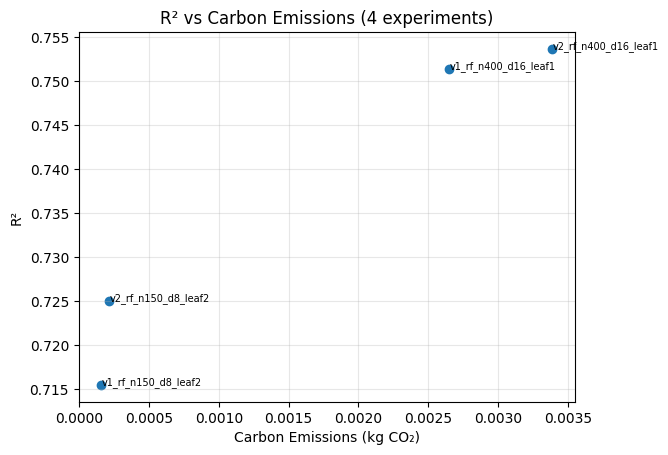

[codecarbon INFO @ 02:47:17] Energy consumed for RAM : 0.009616 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 02:47:17] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 02:47:17] Energy consumed for All CPU : 0.040880 kWh
[codecarbon INFO @ 02:47:17] 0.050495 kWh of electricity and 0.000000 L of water were used since the beginning.


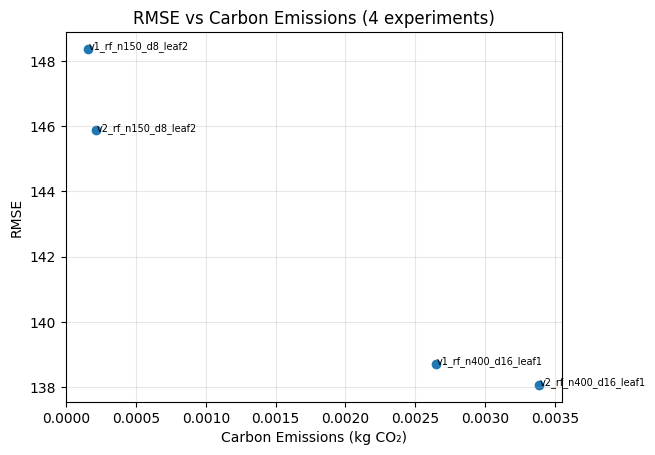

Saved plots: /content/r2_vs_carbon.png /content/rmse_vs_carbon.png


In [ ]:
import matplotlib.pyplot as plt

# Save summary
summary_csv = "/content/experiment_summary.csv"
results_df.to_csv(summary_csv, index=False)
print("Saved:", summary_csv)

# R² vs Carbon
plt.figure()
plt.scatter(results_df["carbon_kg"], results_df["r2"])
for _, r in results_df.iterrows():
    plt.annotate(r["run_name"], (r["carbon_kg"], r["r2"]), fontsize=7)
plt.xlabel("Carbon Emissions (kg CO₂)")
plt.ylabel("R²")
plt.title("R² vs Carbon Emissions (4 experiments)")
plt.grid(True, alpha=0.3)
r2_carbon_path = "/content/r2_vs_carbon.png"
plt.savefig(r2_carbon_path, bbox_inches="tight")
plt.show()

# RMSE vs Carbon
plt.figure()
plt.scatter(results_df["carbon_kg"], results_df["rmse"])
for _, r in results_df.iterrows():
    plt.annotate(r["run_name"], (r["carbon_kg"], r["rmse"]), fontsize=7)
plt.xlabel("Carbon Emissions (kg CO₂)")
plt.ylabel("RMSE")
plt.title("RMSE vs Carbon Emissions (4 experiments)")
plt.grid(True, alpha=0.3)
rmse_carbon_path = "/content/rmse_vs_carbon.png"
plt.savefig(rmse_carbon_path, bbox_inches="tight")
plt.show()

print("Saved plots:", r2_carbon_path, rmse_carbon_path)


**Ranking by predictive performance:**

1. v2_rf_n400_d16_leaf1 (v2)

RMSE 138.06 (best), MAE 100.29 (best), R² 0.7536 (best)

Carbon: 0.003389 kg (highest)

2. v1_rf_n400_d16_leaf1 (v1)

RMSE 138.70, MAE 100.86, R² 0.7514

Carbon: 0.002652 kg

3. v2_rf_n150_d8_leaf2 (v2)

RMSE 145.87, MAE 106.67, R² 0.7250

Carbon: 0.000216 kg

4. v1_rf_n150_d8_leaf2 (v1)

RMSE 148.37, MAE 109.02, R² 0.7155

Carbon: 0.000157 kg (lowest)


**What changed when we moved from v1 → v2 (same model class)**

High-capacity RF (n=400, depth=16):

RMSE improves 138.70 → 138.06 (↓ 0.63, ~0.46%)

MAE improves 100.86 → 100.29 (↓ 0.57, ~0.56%)

R² improves 0.7514 → 0.7536 (↑ 0.0023)

Carbon increases 0.002652 → 0.003389 (↑ 0.000737, ~28%)

Lower-capacity RF (n=150, depth=8):

RMSE improves 148.37 → 145.87 (↓ 2.50, ~1.69%)

MAE improves 109.02 → 106.67 (↓ 2.35, ~2.16%)

R² improves 0.7155 → 0.7250 (↑ 0.0095)

Carbon increases 0.000157 → 0.000216 (↑ 0.000059, ~38%)

Takeaway: v2 consistently wins on metrics. The gain is small for the bigger model, and more noticeable for the smaller model.


**What changed when we increased model capacity (150,d8 → 400,d16)**

This is the biggest effect:

v2: RMSE 145.87 → 138.06 (↓ 7.81, ~5.35%), R² 0.7250 → 0.7536 (↑ 0.0286)

v1: RMSE 148.37 → 138.70 (↓ 9.68, ~6.53%), R² 0.7155 → 0.7514 (↑ 0.0359)

Carbon cost jumps by ~12–17× (0.0002 → 0.0027–0.0034 kg).

“Best” choice depends on  objective

Best accuracy: v2_rf_n400_d16_leaf1

Best accuracy per carbon: v2_rf_n150_d8_leaf2 (very close carbon to v1 small model, materially better metrics)

Best “cheap baseline”: v1_rf_n150_d8_leaf2